In [1]:
import logging
import sys

import matplotlib.pyplot as plt
from scripts.pfa import Path

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

In [2]:
import sys

sys.path.append('../scripts')
sys.path.append('../')
from scripts import centroids_graph_builder
from time import sleep
from multiprocessing import Pool

import numpy as np
from tqdm.notebook import trange, tqdm
from scripts import graph_osm_loader, utils

import networkx as nx
import osmnx as ox
from heapq import heappop, heappush
from itertools import count
from scripts import clustering, pfa, pipeline
from scripts.path_findings.dijkstra_pfa import Dijkstra

In [3]:
def get_rand_graph(N, p):
    G = nx.fast_gnp_random_graph(N, p, directed=False)
    if not nx.is_connected(G):
        tmp = []
        for n in nx.connected_components(G):
            for q in n:
                tmp.append(q)
                break
        for i in range(len(tmp) - 1):
            G.add_edge(tmp[i], tmp[i + 1])
    for e in G.edges:
        G.add_edge(e[0], e[1], length=np.random.random_sample() + 0.001)
    for u in G.nodes:
        if u in G[u]:
            G.remove_edge(u, u)
    return G

In [4]:
NUM_ITERATION = 10  # чтобы уменьшить ошибку при вычислении времени выполнения, при каждом замере время меряется для NUM_ITERATION повторений
WORKER = 5  # количество потоков

In [5]:
GRAPH_ID = 'R2555133'  # R13470549 R2555133 R3766483
# примеры id есть в graph_osm_loader.py
# g = get_rand_graph(1000, 0.1)  # загрузка графа
N = 10000
p = 3 / N
# g = get_rand_graph(N,p)
# g = get_graph()
g = graph_osm_loader.get_graph(GRAPH_ID)
print(len(g.nodes), len(g.edges))

17940 27061


In [6]:
g.remove_edges_from(nx.selfloop_edges(g))

In [7]:
cms = clustering.resolve_k_means_communities(g, resolution=10, max_iteration=100, cluster_name='cluster',
                                             print_log=True)
print(len(cms))

2024-12-21 16:38:02,241 - root - INFO - communities: 497


100%|██████████| 100/100 [00:27<00:00,  3.62it/s]

497


In [8]:
cls2hubs = {}
cls2n = centroids_graph_builder.get_cls2n(g)
for i, c in enumerate(cms):
    for j in cls2n[i]:
        if (i, j) in cls2hubs:
            continue
        a = set()
        b = set()
        for u in c:
            for v in g[u]:
                if v in cms[j]:
                    a.add(u)
                    b.add(v)
        cls2hubs[i, j] = a if len(a) < len(b) else b
        cls2hubs[j, i] = a if len(a) < len(b) else b

In [9]:
cls2hub = {}  # = centroids_graph_builder.get_cls2hubs(g)
for i, j in cls2hubs:
    if i not in cls2hub:
        cls2hub[i] = set()
    cls2hub[i].update(cls2hubs[i, j])
del cls2hubs

In [10]:
np.mean([len(c) for c in cls2hub.values()])

np.float64(11.193158953722333)

In [11]:
hubs = set([u for v in cls2hub.values() for u in v])

In [12]:
hub2id = {h: i for i, h in enumerate(hubs)}
id2hub = {i: h for i, h in enumerate(hubs)}

In [13]:
len(set(hubs))

2710

In [14]:
def dijkstra_pfa_to_set(graph: nx.Graph,
                        start: int,
                        ends: set[int]
                        ) -> \
        tuple[float, list[int]]:
    adjacency = graph._adj
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    fringe = []

    dist[start] = (0.0, None)
    push(fringe, (0.0, next(c), start))
    visited = set()
    
    while fringe:
        (d, _, v) = pop(fringe)
        if v in ends:
            visited.add(v)
        if len(visited) == len(ends):
            break
        
        for u, e in adjacency[v].items():
            vu_dist = d + e['length']
            if u not in dist or dist[u][0] > vu_dist:
                dist[u] = (vu_dist, v)
                push(fringe, (vu_dist, next(c), u))
    return dist


In [15]:
def cals(data_partitions):
    part, hubs, l = data_partitions
    dst = np.zeros((l, l))

    for u in part:
        dst_u = dijkstra_pfa_to_set(g, u, hubs)
        for v in hubs:
            dst[hub2id[u], hub2id[v]] = dst_u[v][0]
    return dst


data = [(list(hubs)[i::WORKER], hubs, len(hubs)) for i in range(WORKER)]
with Pool(WORKER) as p:
    dst = sum(tqdm(p.imap_unordered(cals, data), total=len(data)))

  0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
def cals(data_partitions):
    part, l = data_partitions
    res = {}
    for u in part:
        dst_u = dijkstra_pfa_to_set(g, u, cls2hub[g.nodes()[u]['cluster']])
        for v in cls2hub[g.nodes()[u]['cluster']]:
            node = v
            path = [node]
            while dst_u[node][1]is not None:
                node = dst_u[node][1]
                path.append(node)
            res[u, v] = dst_u[v][0]#, set(g.nodes()[p]['cluster'] for p in path)
    return res

data = [(list(g.nodes)[i::WORKER], hubs) for i in range(WORKER)]
with Pool(WORKER) as p:
    d_nodes = {k: v for d in tqdm(p.imap_unordered(cals, data), total=len(data)) for k, v in d.items()}

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
from pympler.asizeof import asizeof
asizeof(d_nodes)/1024/1024, asizeof(dst)/1024/1024

(43.203041076660156, 56.03117370605469)

In [18]:
nodes = g.nodes()   

In [40]:
def distance(g, u, v):
    c1, c2 = nodes[u]['cluster'], nodes[v]['cluster']
    if c1 == c2:
        return nx.single_source_dijkstra(g,u,v,weight='length')
    return min(d_nodes[u, h1] + d_nodes[v, h2] + dst[hub2id[h1], hub2id[h2]] for h1 in cls2hub[c1] for h2 in cls2hub[c2]), []

In [41]:
def dijkstra_pfa(graph: nx.Graph,
                 start: int,
                 end: int) -> \
        tuple[float, list[int]]:
    if start == end:
        return 0, [start]
    adjacency = graph._adj
    nodes = graph.nodes()
    c = count()
    push = heappush
    pop = heappop
    dist = {}
    pred = {}
    fringe = []
    push(fringe, (0,0.0, next(c), 0, start, None))
    while fringe:
        (_,d, _, n, v, p) = pop(fringe)
        if v in dist:
            continue
        dist[v] = (d, n)
        pred[v] = p
        if v == end:
            break
        for u, e in adjacency[v].items():
            
            l = distance(g, u, end)[0]
            vu_dist = d + e['length']
            
            if u not in dist:
                push(fringe, (vu_dist + l,vu_dist, next(c), n + 1, u, v))
    d, n = dist[end]
    n += 1
    path = [None] * n
    i = n - 1
    e = end
    while i >= 0:
        path[i] = e
        i -= 1
        e = pred[e]
    return d, path


In [42]:
points =utils.generate_points(g)

In [43]:
class Pfa(pfa.PathFinding):    
    def find_path(self, start: int, end: int)-> Path:
        return distance(self.g, start, end)

In [44]:
stat = pipeline.PfaComparator(
    baseline=Dijkstra(g),
    test_algorithm=Pfa(g),
    points=points
).compare()

start 0


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 1


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 2


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

start 3


find paths:   0%|          | 0/250 [00:00<?, ?it/s]

{'whiskers': [<matplotlib.lines.Line2D at 0x7d4efad0f560>,
 'caps': [<matplotlib.lines.Line2D at 0x7d4efad0ce00>,
 'boxes': [<matplotlib.lines.Line2D at 0x7d4efad0ede0>],
 'medians': [<matplotlib.lines.Line2D at 0x7d4efa8c5b50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7d4efa8c5370>],
 'means': []}

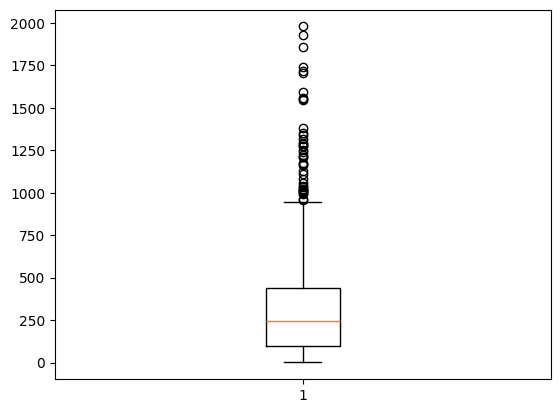

In [45]:
acceleration = stat.get_acceleration()
plt.boxplot(acceleration)

In [46]:
stat.test_length

[np.float64(17020.936993772062),
 np.float64(9496.71636288793),
 np.float64(12461.209981304186),
 np.float64(20840.906123959827),
 np.float64(17388.590341729367),
 np.float64(14232.580678906543),
 np.float64(16350.834579588047),
 np.float64(5144.188539886693),
 np.float64(15378.980994695296),
 np.float64(11030.720133843886),
 np.float64(7387.463623579858),
 np.float64(22700.805523683375),
 np.float64(5753.2566020200575),
 np.float64(18888.242025191852),
 np.float64(17067.459147148653),
 np.float64(14539.070716753087),
 np.float64(10182.682430537687),
 np.float64(15490.786559253564),
 np.float64(19037.273564466563),
 np.float64(31243.841198495444),
 np.float64(9050.563132317493),
 np.float64(16142.285924775591),
 np.float64(9626.057017763102),
 np.float64(10914.150160108966),
 np.float64(14985.594348366265),
 np.float64(23302.91983602313),
 np.float64(19457.76370156592),
 np.float64(19641.548675822694),
 np.float64(11322.079785710008),
 np.float64(9512.144628899665),
 np.float64(21479.9

In [47]:
stat


        err_max:    0.0000
        err_min:    -0.0000
        err_median: 0.0000
        err_mean:   -0.0000
        
        acceleration_max:    1978.7332
        acceleration_min:    0.2379
        acceleration_median: 244.0241
        acceleration_mean:   318.8732
        